In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.constants import e, m_p, c

In [2]:
!cat madx/sis18.lat

! Element definitions:
! ------------------- horizontal quadrupole ----------------------------
QS1F: QUADRUPOLE, L=1.04, K1=0.282632;
QS2D: QUADRUPOLE, L=1.04, K1=-0.492;
QS3T: QUADRUPOLE, L = 0.4804, K1 = 0.656;
!---------------------  DRIFT SPACES DEFINITION  ---------------------
DR1: DRIFT, L=0.6450000;
DR2: DRIFT, L=0.9700000;
DR3: DRIFT, L=6.8390117;
DR4: DRIFT, L=0.6000000;
DR5: DRIFT, L=0.7098000;
DR6: DRIFT, L=0.4998000;
!--------------------------  BENDING MAGNET ---------------------------
ALPHA  := 15 * 1/57.2958;
LL  := 150 * 1/57.2958;
RB: SBEND, L=2.6175, ANGLE=ALPHA;

! ---------------------------  LINE DEFINITION --------------------------
! Sections without injection devices, steeres and position monitors
CELLA: LINE=(DR1, RB, DR2, RB, DR3, QS1F, DR4, QS2D, DR5, QS3T, DR6);

FODO: LINE = (12*CELLA);


RETURN;


In [3]:
from cpymad.madx import Madx

In [4]:
madx = Madx()
madx.options.echo = False
madx.options.info = False # avoiding output in tracking, makes a huge timing difference!!!


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.05.20 14:43:32      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [5]:
madx.call(file="madx/sis18.lat")

In [6]:
p0c = 6 * 1e9 # in eV
Etot = np.sqrt(p0c**2 + (m_p/e)**2 * c**4) * 1e-9 # in GeV

In [7]:
Etot

6.072919767202941

In [8]:
madx.command.beam(particle='proton', energy=str(Etot)) # energy in GeV

True

In [9]:
madx.use(sequence="FODO")

In [10]:
madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
       216.7081404                 -0      0.03859362031        5.090286657 

                q1                dq1            betxmax              dxmax 
       4.577501457       -4.130454489        15.39960299        2.438781128 

             dxrms             xcomax             xcorms                 q2 
        1.87333493                  0                  0        2.718992979 

               dq2            betymax              dymax              dyrms 
      -6.521429582         29.6324848                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [11]:
assert madx.command.select(
    flag='MAKETHIN',
    CLASS='QUADRUPOLE',
    SLICE='8',
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='SBEND',
    slice_='8',
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='RBEND',
    slice_='8',
)

In [12]:
madx.command.makethin(
    makedipedge=False,
    style='teapot',
    sequence='FODO',
)

makethin: style chosen : teapot
makethin: slicing sequence : fodo


True

In [13]:
madx.use(sequence="FODO") # important in order to consistently use thin lense lattice!

In [14]:
twiss = madx.twiss()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
       216.7081404                 -0      0.03859155172         5.09042308 

                q1                dq1            betxmax              dxmax 
       4.577598169       -4.337325087        15.52637808        2.457595991 

             dxrms             xcomax             xcorms                 q2 
       1.851915623                  0                  0        2.718441832 

               dq2            betymax              dymax              dyrms 
       -6.04407507        33.60548239                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

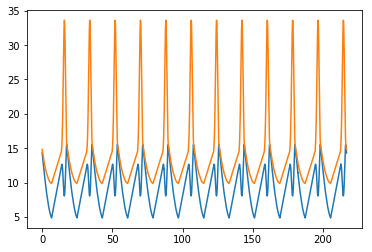

In [15]:
plt.plot(twiss['s'], twiss['betx'])
plt.plot(twiss['s'], twiss['bety']);

In [18]:
len(madx.sequence.fodo.elements)

542

# Timing of MAD-X Tracking

On the Dell Latitude 5290 with intel i5-8250U we benchmark:

In [19]:
import time
class Timer(object):
    def __init__(self):
        self.interval = 0

    def __enter__(self):
        self.t0 = time.time()
        return self

    def __exit__(self, *args, **kwargs):
        self.t1 = time.time()
        self.interval = self.t1 - self.t0
        return False

In [20]:
def prepare_track(npart):
    madx.command.track(onetable=True)
    madx.input('NPART={:d};'.format(npart))
    madx.input('''
N=0; WHILE (N<NPART) {
    XS = 1e-6/(N+1);
    START, X=XS;
    N = N+1;
    ! VALUE, N;
}
''')

def run_track(nturns):
    madx.command.run(turns=nturns, ffile=nturns)

def tear_down():
    madx.command.endtrack()

def timeit(npart, nturns, repeat=1):
    res = 0
    for i in range(repeat):
        prepare_track(npart)
        with Timer() as t:
            run_track(nturns)
            tear_down()
        res = (res * i + t.interval) / (i + 1)

    print ('The job took {:.3f} s for {} particles and {} turns (mean of {} loops).'.format(
        res, npart, nturns, repeat))

### result for $1$ turn and $1\times 10^5$ particles:

In [21]:
timeit(npart=100000, nturns=1)

enter TRACK module
exit TRACK module

The job took 1.520 s for 100000 particles and 1 turns (mean of 1 loops).


### result for $1\times 10^5$ turns and $1$ particle:

In [22]:
timeit(npart=1, nturns=int(1e5))

enter TRACK module
exit TRACK module

The job took 186.685 s for 1 particles and 100000 turns (mean of 1 loops).


### result for $1$ turn and $1\times 10^6$ particles:

In [21]:
timeit(npart=int(1e6), nturns=1)

enter TRACK module
exit TRACK module

The job took 20.720 s for 1000000 particles and 1 turns (mean of 1 loops).


.

.

.

.

.

.

# disregard: slow timings with `madx.options.info == True`

====

### for $1\times 10^6$ particles:

In [23]:
t.interval

234.40291285514832

### for $1\times 10^5$ particles:

In [22]:
t.interval

22.97009015083313

In [21]:
t.interval

23.105098009109497

### for $1$ particle and $1\times 10^5$ turns:

In [33]:
t.interval

247.38382005691528

### checking the output:

In [23]:
madx.input('WRITE, TABLE=TRACKSUMM, FILE=tracksumm.dat;')

True